# `Why Do Patients Get Readmitted?`

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-dark')
 
from sqlalchemy import create_engine,text
user = 'root'
passwords = '7003890541'
host = 'localhost'
port = 3306
database = 'synthea'

engine = create_engine(f"mysql+pymysql://{user}:{passwords}@{host}:{port}/{database}")
def sql(query , engine = engine):
    return pd.read_sql(query,engine)


def select(table_name):
    return sql(f'select * from {table_name} limit 5')


def run(query):
    with engine.connect() as con:
        con.execute(text(query))
        con.commit()

In [6]:
select('encounters').head(1)

,id,start,stop,patient,organization,provider,payer,class,description,basic_cost,total_cost,payer_coverage,reason
0,d0c40d10-8d87-447e-836e-99d26ad52ea5,2010-01-23 17:45:28,2010-01-23 18:10:28,034e9e3b-2def-4559-bb2a-7850888ae060,e002090d-4e92-300e-b41e-7d1f21dee4c6,e6283e46-fd81-3611-9459-0edb1c3da357,6e2f1a2d-27bd-3701-8d08-dae202c58632,ambulatory,encounter for symptom,129.16,129.16,54.16,acute bronchitis (disorder)


In [9]:
sql('''
    with duplicate as(
    select reason,class from encounters where class = 'wellness')
    select reason, count(reason) as reason_count from duplicate
    group by reason
    order by reason_count desc;
''')

,reason,reason_count
0,unknown,19106


`OKAY SO 'REASON' IS 'UNKNOWN' MEANS THE PATIENT IS FROM GENERAL VISIT, WHICH CAN NOT BE CONSIDERED AS A READMISSION, SO WE CAN IGNORE THESE ROWS`

In [26]:
readmission_encounter_id = sql(
    '''
    with duplicate as (
    select first.id,date(first.start) as prev_date, date(date_add(first.start, interval 30 day)) as after_30_days,
    second.id as next_id, date(second.start) as next_date
    from encounters first
    join encounters second
    where first.patient = second.patient and
    second.start > first.start and
    second.start <= date_add(first.start,interval 30 day) and
    second.class != 'wellness')
    select distinct next_id from duplicate;
'''
)

In [27]:
readmission_encounter_id

,next_id
0,04f69a96-6f77-4ca6-95f5-b7a45bb9e476
1,8c929690-1826-4b84-81c9-b36f40f21763
2,d5e43f88-27a4-44d3-ba66-3cc5b578f527
3,470ccc46-0d6b-4a60-9f52-f3adaa7ac08f
4,f4a62b3b-a3fc-4c7b-9752-47cf0bdc8659
...,...
19236,d8c26003-aa24-4d23-aa06-9f8f8ce85a85
19237,301da974-a232-48ad-b4ae-23663ceb9e7f
19238,b92873dd-c7a7-43dd-85fc-5a5a5910cd58
19239,c684e416-d617-4ea9-a821-d8e590a98892


In [59]:
query = '''
    create table data as
    select * from encounters;
'''
run(query)

In [60]:
run('''
    alter table data
    add column readmission tinyint(1) default 0;    
''')

In [73]:
ids = "', '".join(readmission_encounter_id['next_id'])
ids = f"'{ids}'"      # wrap with quotes

query = f"""
UPDATE data
SET readmission = 1
WHERE id IN ({ids});
"""

run(query)

`MAIN DATASET IS CREATED FOR ANALYSIS`

In [75]:
select('data')

,id,start,stop,patient,organization,provider,payer,class,description,basic_cost,total_cost,payer_coverage,reason,readmission
0,d0c40d10-8d87-447e-836e-99d26ad52ea5,2010-01-23 17:45:28,2010-01-23 18:10:28,034e9e3b-2def-4559-bb2a-7850888ae060,e002090d-4e92-300e-b41e-7d1f21dee4c6,e6283e46-fd81-3611-9459-0edb1c3da357,6e2f1a2d-27bd-3701-8d08-dae202c58632,ambulatory,encounter for symptom,129.16,129.16,54.16,acute bronchitis (disorder),0
1,e88bc3a9-007c-405e-aabc-792a38f4aa2b,2012-01-23 17:45:28,2012-01-23 18:00:28,034e9e3b-2def-4559-bb2a-7850888ae060,772ee193-bb9f-30eb-9939-21e86c8e4da5,6f1d59a7-a5bd-3cf9-9671-5bad2f351c28,6e2f1a2d-27bd-3701-8d08-dae202c58632,wellness,general examination of patient (procedure),129.16,129.16,129.16,unknown,0
2,8f104aa7-4ca9-4473-885a-bba2437df588,2001-05-01 15:02:18,2001-05-01 15:17:18,1d604da9-9a81-4ba9-80c2-de3375d59b40,5d4b9df1-93ae-3bc9-b680-03249990e558,af01a385-31d3-3c77-8fdb-2867fe88df2f,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,ambulatory,encounter for symptom,129.16,129.16,0.00,sinusitis (disorder),0
3,b85c339a-6076-43ed-b9d0-9cf013dec49d,2011-07-28 15:02:18,2011-07-28 15:17:18,1d604da9-9a81-4ba9-80c2-de3375d59b40,3dc9bb2d-5d66-3e61-bf9a-e234c6433577,bb17e691-262b-3546-93d5-d88e7de93246,b1c428d6-4f07-31e0-90f0-68ffa6ff8c76,wellness,general examination of patient (procedure),129.16,129.16,0.00,unknown,0
4,dae2b7cb-1316-4b78-954f-fa610a6c6d0e,2010-07-27 12:58:08,2010-07-27 13:28:08,10339b10-3cd1-4ac3-ac13-ec26728cb592,b03dba4f-892f-365c-bfd1-bfcfa7a98d5d,7ed6b84a-b847-3744-9d42-15c42297a0c2,d47b3510-2895-3b70-9897-342d681c769d,wellness,general examination of patient (procedure),129.16,129.16,129.16,unknown,0


**READMISSION STATUS BASED ON ENCOUNTER TABLE ONLY**

In [105]:
query = '''
    select year(start) as year, count(year(start)) as readmission_count from data
    group by year(start)
    order by year asc;
'''

patients_over_the_years = sql(query)

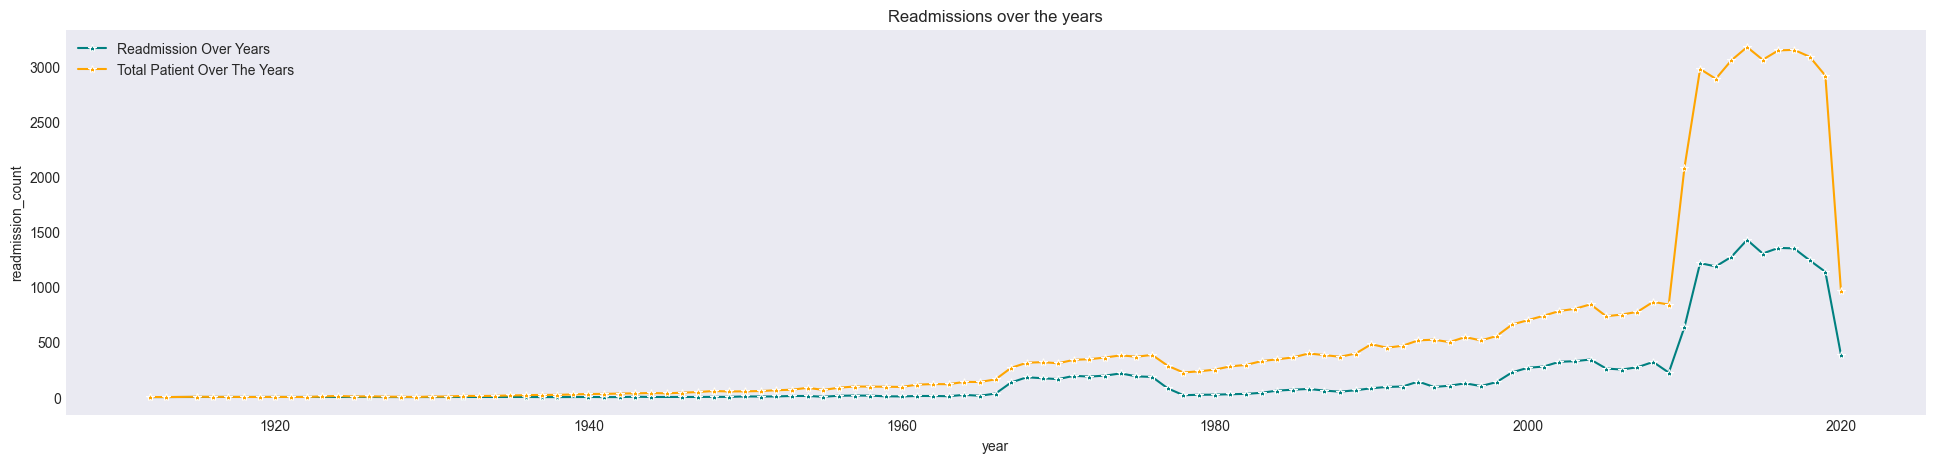

In [107]:
query = '''
    select year(start) as year, count(year(start)) as readmission_count from data
    where readmission = '1'
    group by year(start)
    order by year asc;
'''
tab = sql(query)

plt.figure(figsize=(24,5))
sns.lineplot(x = 'year',y= 'readmission_count',data = tab,color = 'teal',marker = "*",label = 'Readmission Over Years')
sns.lineplot(x = 'year',y= 'readmission_count',data = patients_over_the_years,color = 'orange',marker = "*",label = 'Total Patient Over The Years')
plt.title('Readmissions over the years')
plt.legend()
plt.show()